In [1]:
require(ggplot2)
require(mgcv)
require(lme4)
require(dplyr)
require(akima)
require(grid)
require(gridExtra)

Loading required package: ggplot2

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Loading required package: lme4

Loading required package: Matrix


Attaching package: 'lme4'


The following object is masked from 'package:nlme':

    lmList


Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: akima

Loading required package: grid

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
data = read.csv("data/aligned_ac_data.csv")[,-1]
names(data) = gsub("comp\\.([12])", "comp\\1", names(data))
data$filename = factor(data$filename)
data$collapse_func = factor(data$collapse_func)

In [3]:
head(data)

,ac_id,has_match,time_start,time_end,time_midpoint,speaker_gender,context_raw,position,syllable_structure,nasalized_perceived,⋯,offset_id,offset_s,phone,filename,comp1,comp2,next_offset_s,emit_id,has_midpoint,collapse_func
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>
1,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,439,13.17,n,劉櫂豪-127903,27.941244,29.770956,13.38,18,False,b
2,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,446,13.38,y,劉櫂豪-127903,-30.644875,-5.742225,13.50,19,False,b
3,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,450,13.50,ɕ,劉櫂豪-127903,57.967636,-22.112434,13.56,20,False,b
4,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,452,13.56,a,劉櫂豪-127903,-6.503804,41.149845,13.92,21,True,b
5,105,yes,21.15613,21.80866,21.73240,m,h_oN_f,f,cv,1,⋯,707,21.21,p,劉櫂豪-127903,-4.906386,-52.821700,21.27,36,False,b
6,105,yes,21.15613,21.80866,21.73240,m,h_oN_f,f,cv,1,⋯,709,21.27,u,劉櫂豪-127903,-66.930750,16.007505,21.36,37,False,b


In [4]:
drop_outlier = function(df){
    qs_1 = quantile(df$comp1, c(0.05, 0.95))
    qs_2 = quantile(df$comp2, c(0.05, 0.95))
    
    mask_1 = (df$comp1 >= qs_1[1]) & (df$comp1 <= qs_2[2])    
    mask_2 = (df$comp2 >= qs_2[1]) & (df$comp2 <= qs_2[2])    
    df[(mask_1 | mask_2),]
}

In [5]:
hull_data = data %>% group_by(phone) %>% 
                group_modify(~drop_outlier(.x)) %>%
                filter(n() > 3) %>%
                slice(chull(comp1, comp2)) %>% 
                ungroup()

In [6]:
hull_median = hull_data %>% 
                group_by(phone) %>% 
                group_modify(~data.frame(
                       comp1=mean(.x$comp1), 
                       comp2=mean(.x$comp2))) %>%
                ungroup()

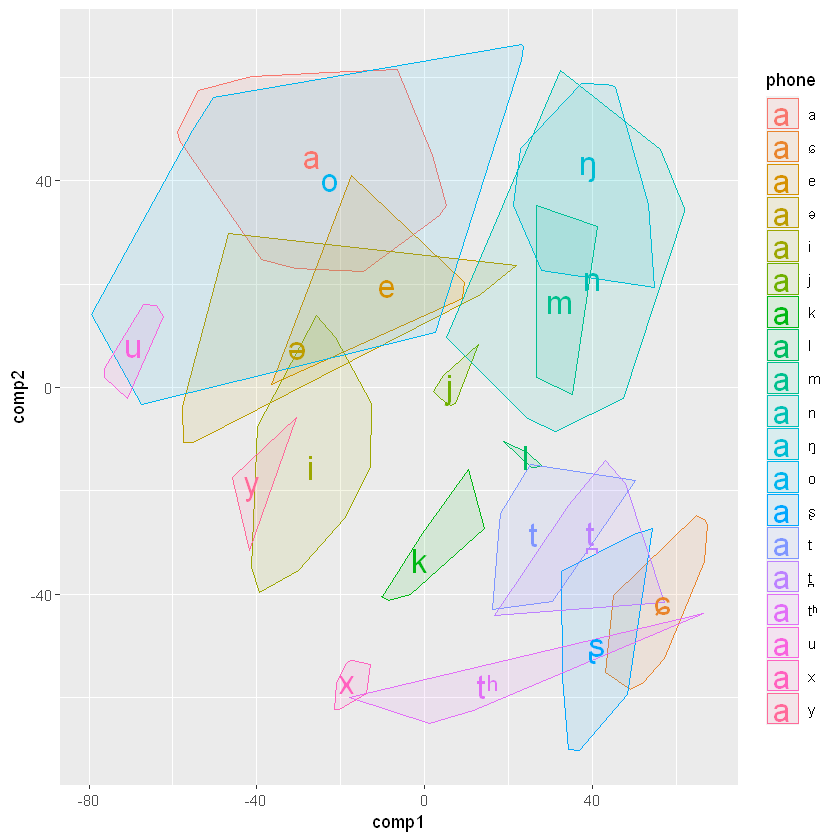

In [7]:
ggplot(hull_data, aes(x=comp1, y=comp2, color=phone, fill=phone)) + 
    geom_polygon(alpha=0.1) +     
    geom_text(data=hull_median, aes(label=phone), size=7)    

## Vowel data

In [8]:
# selected_phones = "[aeioənŋ]"
vdata = data[data$phone %in% unlist(strsplit("aeiyouə", split='')), ]

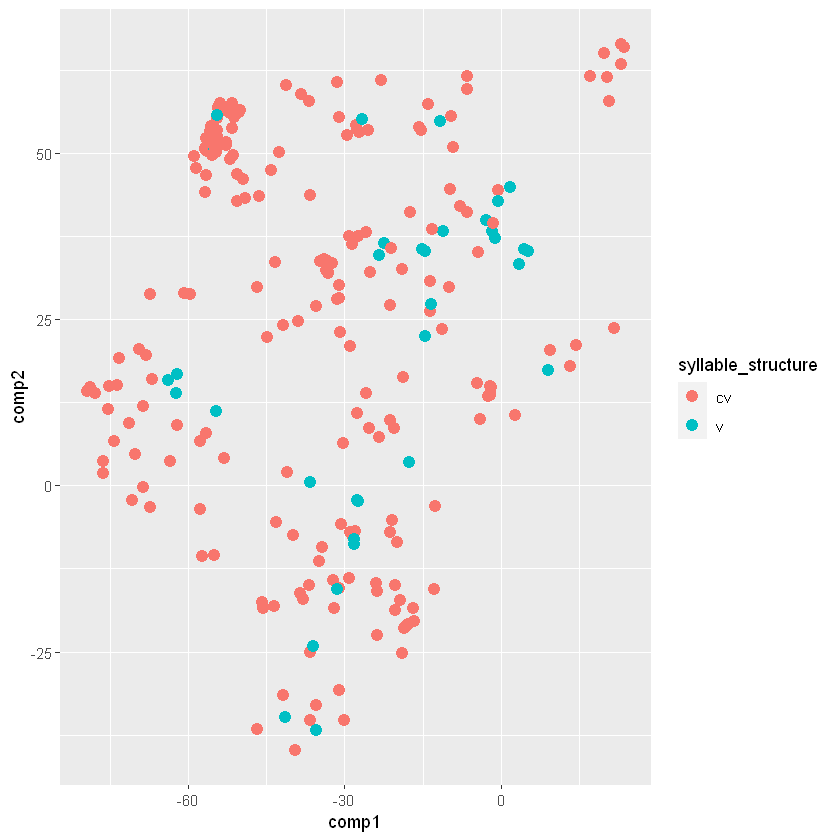

In [9]:
ggplot(vdata, aes(x=comp1, y=comp2, color=syllable_structure)) + 
    geom_point(size=3)

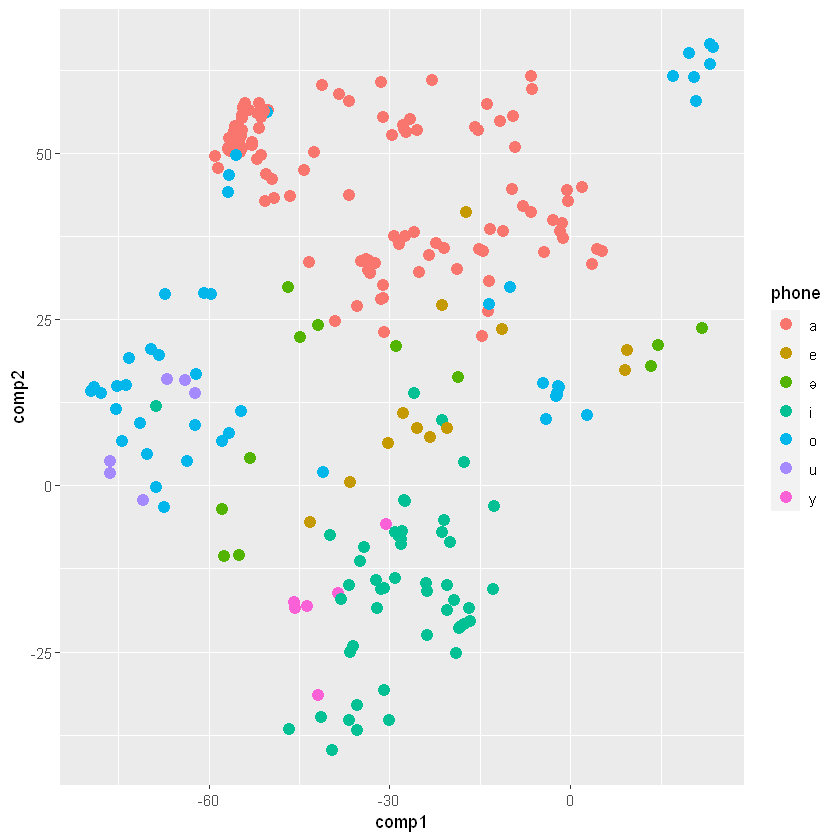

In [10]:
ggplot(vdata, aes(x=comp1, y=comp2, color=phone)) + 
    geom_point(size=3)

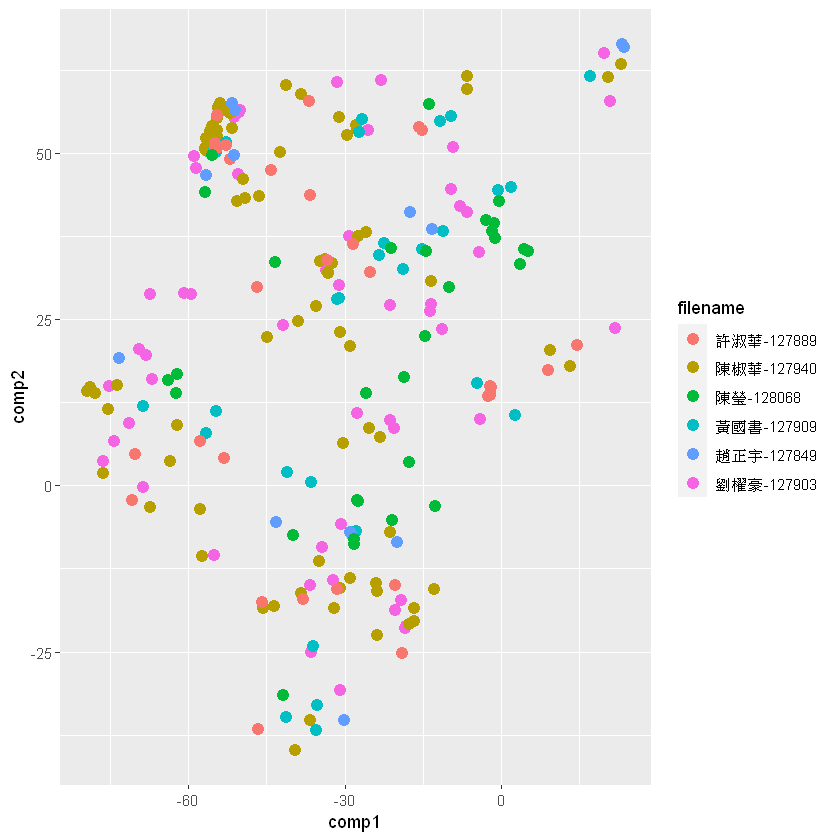

In [11]:
ggplot(vdata, aes(x=comp1, y=comp2, color=filename)) + 
    geom_point(size=3)

In [12]:
nrow(vdata)

[1] 262

In [13]:
length(unique(vdata$ac_id))

[1] 140

## Mixed model

In [14]:
m_f1 = lmer(freq_f1~comp1+comp2+(1|filename), data=vdata)
summary(m_f1)

Linear mixed model fit by REML ['lmerMod']
Formula: freq_f1 ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 3364.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2668 -0.4620  0.0357  0.4674  3.3075 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept)  2289     47.85  
 Residual             22190    148.96  
Number of obs: 262, groups:  filename, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept) 726.94180   27.29482  26.633
comp1        -0.04142    0.41155  -0.101
comp2         0.34596    0.33235   1.041

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.494       
comp2 -0.314 -0.015

In [15]:
ranef(m_f1)

$filename
              (Intercept)
許淑華-127889    51.37552
陳椒華-127940    38.26085
陳瑩-128068     -34.15729
黃國書-127909    14.24298
趙正宇-127849   -55.97470
劉櫂豪-127903   -13.74736

with conditional variances for "filename" 

In [16]:
m_f2 = lmer(freq_f2~comp1+comp2+(1|filename), data=vdata)
summary(m_f2)

Linear mixed model fit by REML ['lmerMod']
Formula: freq_f2 ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 3654.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5470 -0.5013 -0.2547  0.1794  4.5663 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept)  1522     39.01  
 Residual             69314    263.28  
Number of obs: 262, groups:  filename, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept) 1209.5474    36.9889  32.700
comp1         -0.2283     0.7182  -0.318
comp2         -0.3574     0.5861  -0.610

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.651       
comp2 -0.408 -0.006

In [17]:
ranef(m_f2)

$filename
              (Intercept)
許淑華-127889    9.280289
陳椒華-127940    2.091414
陳瑩-128068    -15.045691
黃國書-127909   24.314773
趙正宇-127849   22.751392
劉櫂豪-127903  -43.392178

with conditional variances for "filename" 

In [18]:
m_f3 = lmer(freq_f3~comp1+comp2+(1|filename), data=vdata)
summary(m_f3)

Linear mixed model fit by REML ['lmerMod']
Formula: freq_f3 ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 3755.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6833 -0.6847 -0.2341  0.4345  2.8951 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept)   1411    37.56  
 Residual             102842   320.69  
Number of obs: 262, groups:  filename, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept) 2.760e+03  4.338e+01  63.630
comp1       1.160e+00  8.708e-01   1.333
comp2       2.485e-02  7.133e-01   0.035

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.678       
comp2 -0.423 -0.002

In [19]:
m_nas = lmer(nasality~comp1+comp2+(1|filename), data=vdata)
summary(m_nas)

Linear mixed model fit by REML ['lmerMod']
Formula: nasality ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 1700.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0228 -0.2842  0.1349  0.5741  2.3361 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept) 18.98    4.357   
 Residual             34.96    5.913   
Number of obs: 262, groups:  filename, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept) 5.225182   1.934824   2.701
comp1       0.015506   0.016422   0.944
comp2       0.009252   0.013204   0.701

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.276       
comp2 -0.176 -0.019

## Get prediction error (bootstrap)

In [20]:
pred.func <- function(fit) {
    predict(fit, re.form=NA)
}
nbin=4

### F1 predictions

In [21]:
boot_lmer = function(lme_obj){
    boot_obj = bootMer(lme_obj, nsim=200, FUN=pred.func,seed=101)
    pred_mean = apply(boot_obj$t, 2, mean)
    pred_se = apply(boot_obj$t, 2, sd)
    interp_se = interp(vdata$comp1, vdata$comp2, pred_se)    
    interp_M = interp(vdata$comp1, vdata$comp2, pred_mean)
    grid_obj = expand.grid(interp_M$x, interp_M$y)
    names(grid_obj) = c("comp1", "comp2")
    grid_obj$M = as.numeric(interp_M$z)    
    grid_obj$se = as.numeric(interp_se$z)
    grid_obj = grid_obj[apply(!is.na(grid_obj[,c("M", "se")]), 1, all),]
    list(pred_mean=pred_mean, pred_se=pred_se, grid_df=grid_obj)
}

In [22]:
boot_pred_f1 = boot_lmer(m_f1)
boot_pred_f2 = boot_lmer(m_f2)
boot_pred_f3 = boot_lmer(m_f3)
boot_pred_nas = boot_lmer(m_nas)

In [23]:
Gn = "#1b9e77"
Rd = "#d95f02"
plot_acoustic_effect = function(boot_pred, var_label, 
                                k=0.2, breaks=NULL){
    pred_mean = boot_pred$pred_mean
    pred_se = boot_pred$pred_se
    grid_df = boot_pred$grid_df
    pred_df = data.frame(x=vdata$comp1, y=vdata$comp2, pred=pred_mean)
    
    if (!is.null(breaks)) {
        M_breaks = breaks
    } else {
        M_breaks = pretty(pred_mean, n=3)
    }
    
    # note sen1 is for +1se, sep1 is for -1se,
    # they all use the same breaks from M, 
    # therefore drawing the same contour line on sen1 is the same as drawing +1se
    # c.f. https://github.com/cran/mgcv/blob/a534170c82ce06ccd8d76b1a7d472c50a2d7bbd2/R/plots.r#L802

    ggplot() + theme_classic() + 
        geom_raster(data=grid_df, aes(x=comp1, y=comp2, fill=M)) +                
        scale_fill_distiller(palette='RdYlGn', direction=1, name=var_label) + 
        geom_contour(data=grid_df, aes(x=comp1, y=comp2, z=M), 
                     color="#636363", breaks=M_breaks, size=1) +
        geom_contour(data=grid_df, aes(x=comp1, y=comp2, z=I(M-k*se)),  # +k*se
                     color=Gn, breaks=M_breaks, size=1, linetype="longdash") +
        geom_contour(data=grid_df, aes(x=comp1, y=comp2, z=I(M+k*se)),  # -k*se
                     color=Rd, breaks=M_breaks, size=1, linetype="longdash") +    
        # geom_point(data=pred_df, aes(x=x, y=y), size=1, color="#333333", shape=20) +
        theme(axis.title=element_text(size=12, color="#333333"), 
              axis.text.x=element_text(size=12),
              axis.text.y=element_text(size=12),               
              plot.title=element_text(size=16, hjust=0.5),              
              legend.key.size=unit(1, 'cm'),
              legend.key.height=unit(0.5, 'cm'),
              legend.position="bottom",
              legend.title=element_blank(),
              legend.text=element_text(size=12)) + 
        xlab("tSNE-1") + ylab("tSNE-2") + ggtitle(var_label)
}

In [24]:
options(repr.plot.width=12, repr.plot.height=4, repr.plot.res=200)
p1 = plot_acoustic_effect(boot_pred_f1, "F1 Freq")
p2 = plot_acoustic_effect(boot_pred_f2, "F2 Freq")
p3 = plot_acoustic_effect(boot_pred_f3, "F3 Freq")
p4 = plot_acoustic_effect(boot_pred_nas, "Nasality")
p_grid = arrangeGrob(p1, p2, p3, p4, nrow=1)

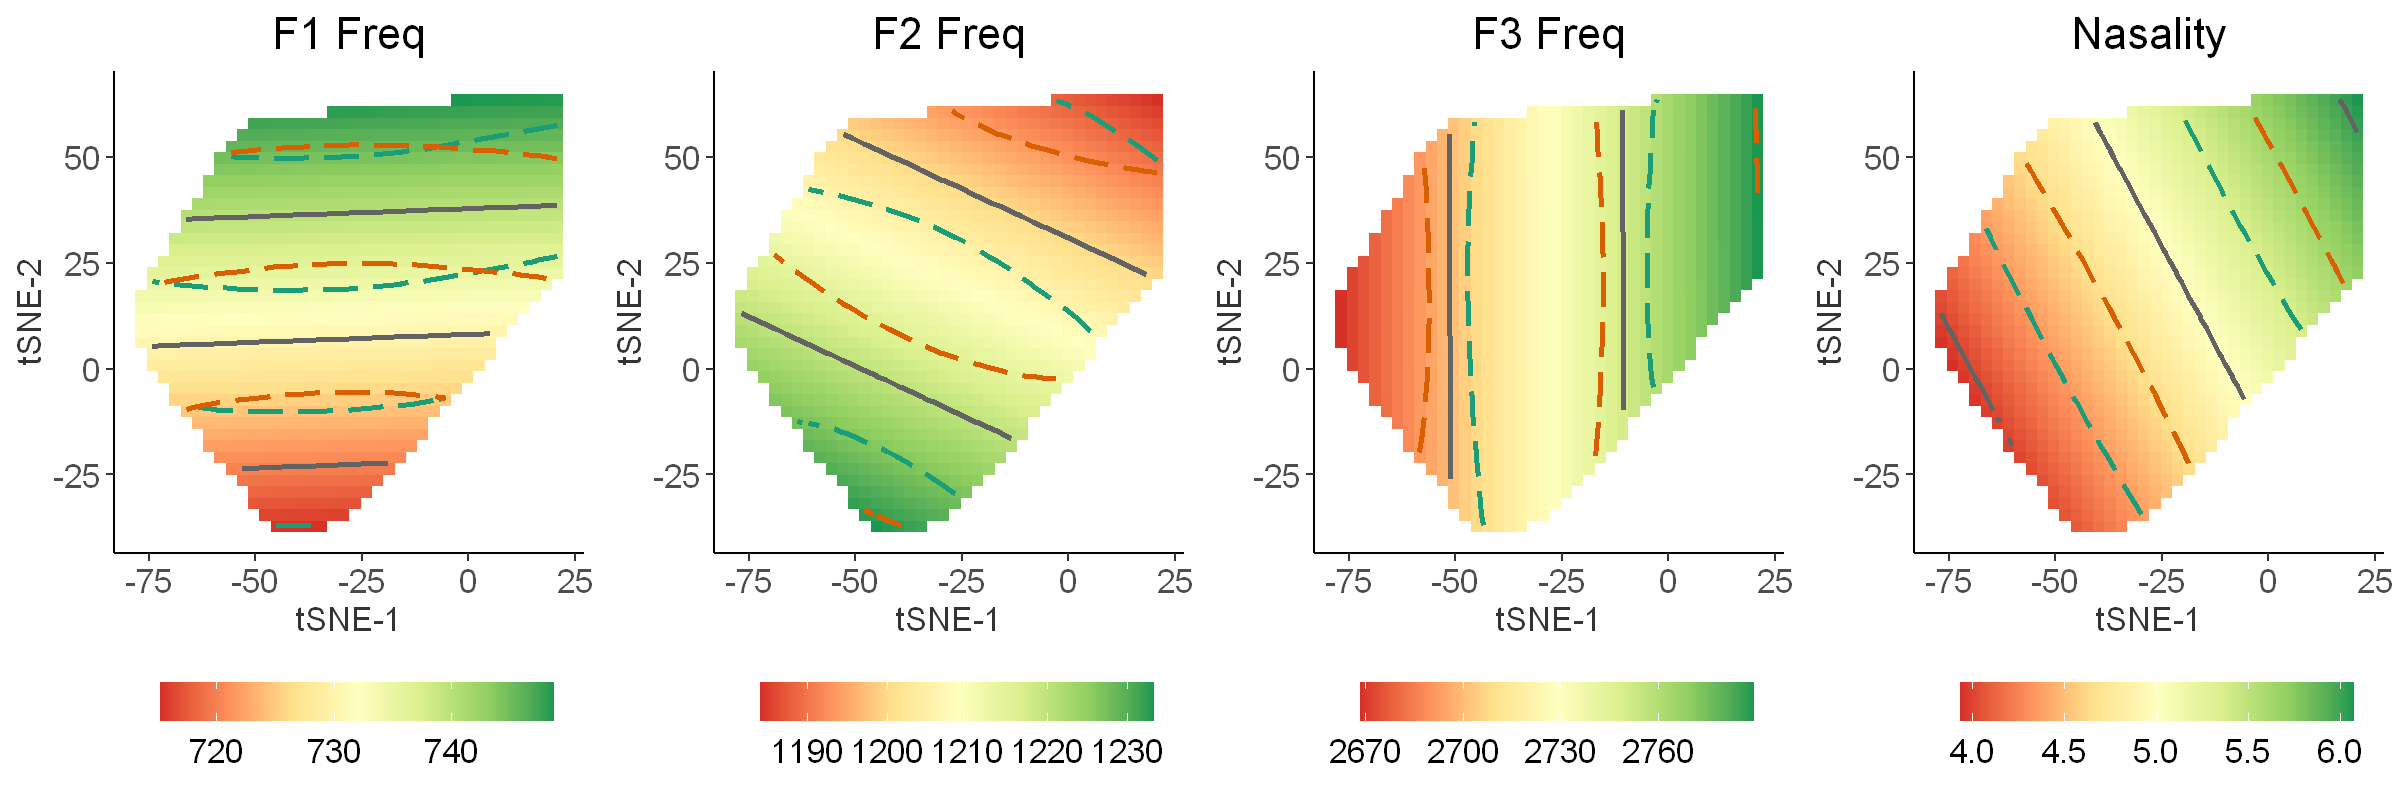

In [25]:
grid.draw(p_grid)

In [26]:
png("ac_tsne.png", width=12, height=4, units="in", res=200)
grid.draw(p_grid)
dev.off()

png 
  2